Problem Statement
Typically a house in Manhattan comprises of various electrical appliances. Each of these appliances partly contributes to the total energy consumption of the house. If these houses are grouped based on their power usage, it helps to analyze the requirement of electric power in different parts of the city. Also, the insights can be useful to identify the appliances with high and low usage of electricity. In this case study, we consider the power consumption due to various appliances in the house and try to group the houses as per their power consumption.

Data Definition
The dataset represents the electric power consumption in the house. The data definition is as follows:

Global_active_power: The global minute-averaged active power of the house (in KW)

Global_reactive_power: The global minute-averaged reactive power of the house (in KW)

Voltage: The minute-averaged voltage of the house (in volt)

Global_intensity: The global minute-averaged current intensity of the house (in ampere)

Kitchen_consumption: The power consumption of the appliances in the kitchen (in watt-hour)

Laundry_consumption: The power consumption of the appliances in the laundry room (in watt-hour)

Other_appliances_consumption: The power consumption of the appliances other than in the kitchen and laundry room (in watt-hour)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster.hierarchy import linkage,dendrogram,cophenet

np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('power.xlsx')

In [3]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,2.242,0.162,237.33,10.0,1,7,17
1,3.714,0.296,235.15,15.8,2,35,17
2,3.212,0.304,235.99,14.2,1,26,17
3,3.694,0.280,235.16,15.6,1,35,17
4,3.204,0.292,236.08,14.0,1,27,17
...,...,...,...,...,...,...,...
21235,2.812,0.290,239.05,11.8,2,2,17
21236,2.758,0.290,238.61,11.6,1,1,18
21237,2.750,0.286,238.07,11.6,2,1,17
21238,2.918,0.268,237.10,12.4,1,1,18


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,21240.0,3.290522,1.625414,0.302,1.866,3.184,4.246,9.994
Global_reactive_power,21240.0,0.259400,0.144701,0.046,0.148,0.236,0.342,1.198
Voltage,21240.0,237.324997,3.416039,225.120,235.180,237.500,239.570,249.150
Global_intensity,21240.0,14.020800,6.969000,1.200,8.000,13.600,18.000,43.400
Kitchen_consumption,21240.0,13.424529,16.472617,1.000,1.000,2.000,36.000,40.000
Laundry_consumption,21240.0,9.266667,13.661116,1.000,1.000,2.000,15.000,60.000
Other_appliances_consumption,21240.0,16.654379,4.156162,1.000,17.000,17.000,18.000,30.000


In [5]:
# Check for missing values

In [6]:
data.isnull().sum()

Global_active_power             0
Global_reactive_power           0
Voltage                         0
Global_intensity                0
Kitchen_consumption             0
Laundry_consumption             0
Other_appliances_consumption    0
dtype: int64

In [7]:
# Check the distribution and outliers in the data

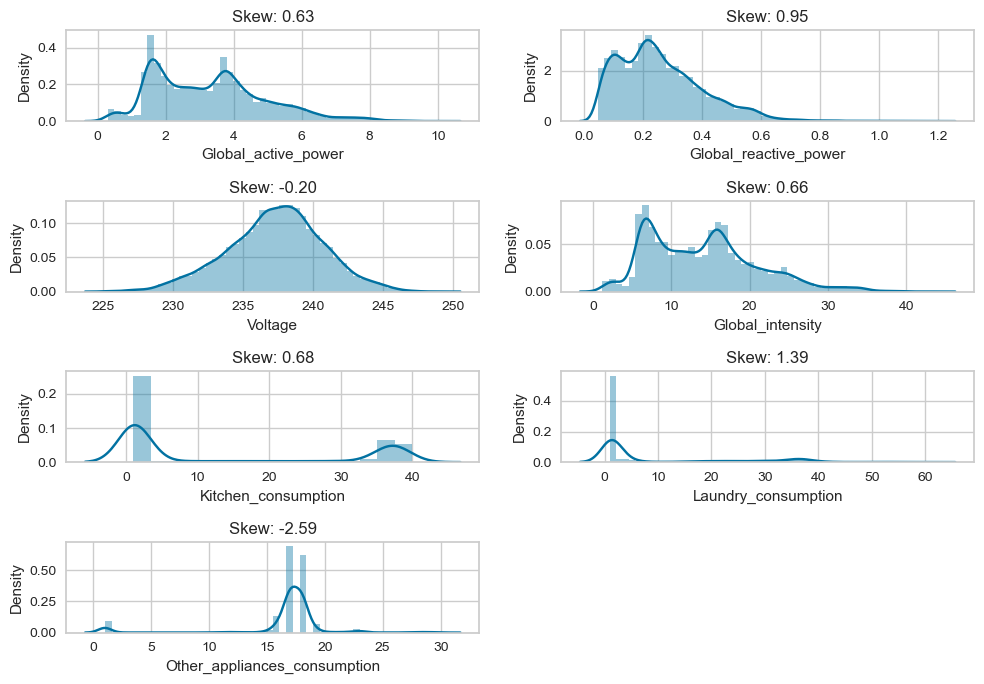

In [8]:
t=1
plt.figure(figsize=(10,7))
for i in data.columns:
    plt.subplot(4,2,t)
    sns.distplot(data[i])
    plt.title('Skew: %.2f'%data[i].skew())
    t+=1
plt.tight_layout()
plt.show()

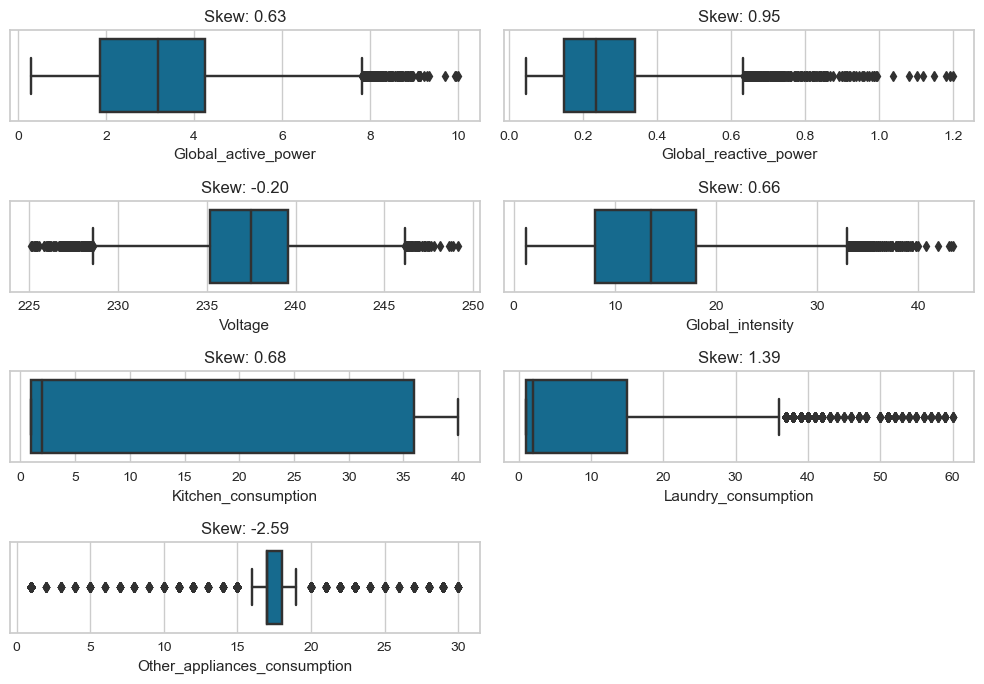

In [9]:
t=1
plt.figure(figsize=(10,7))
for i in data.columns:
    plt.subplot(4,2,t)
    sns.boxplot(data[i])
    plt.title('Skew: %.2f'%data[i].skew())
    t+=1
plt.tight_layout()
plt.show()

In [10]:
for i in data.select_dtypes(np.number).columns:
    q1,q3 = np.quantile(data[i],[0.25,0.75])
    iqr = q3-q1
    ul = q3+(3.5*iqr)
    ll = q1-(3.5*iqr)
    data = data[~((data[i]>ul)|(data[i]<ll))]

In [11]:
data.shape

(19075, 7)

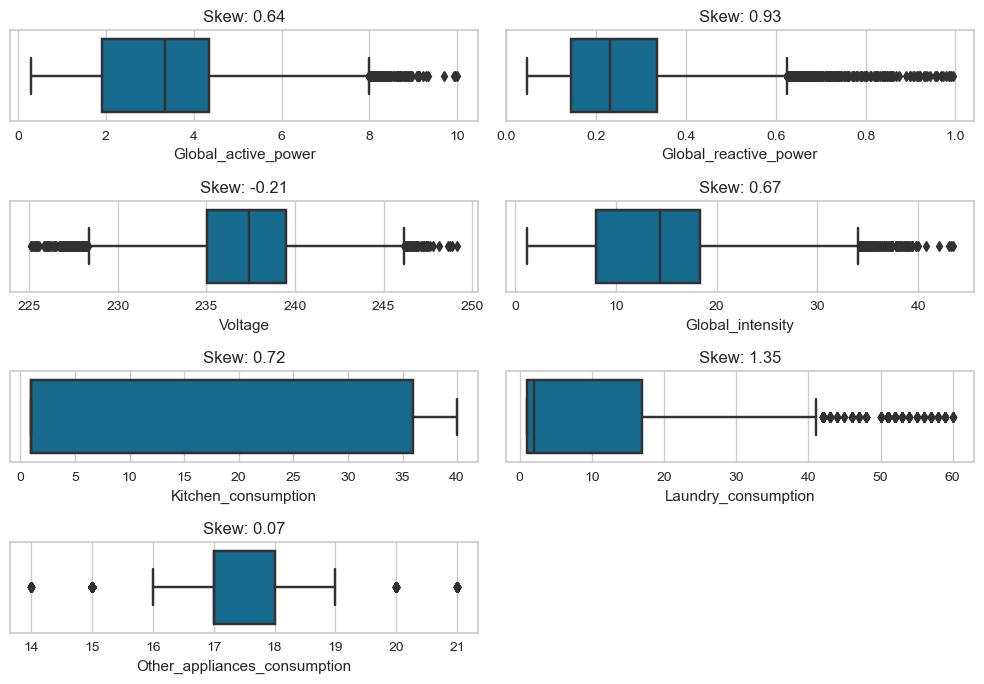

In [12]:
t=1
plt.figure(figsize=(10,7))
for i in data.columns:
    plt.subplot(4,2,t)
    sns.boxplot(data[i])
    plt.title('Skew: %.2f'%data[i].skew())
    t+=1
plt.tight_layout()
plt.show()

In [13]:
# Pairplot

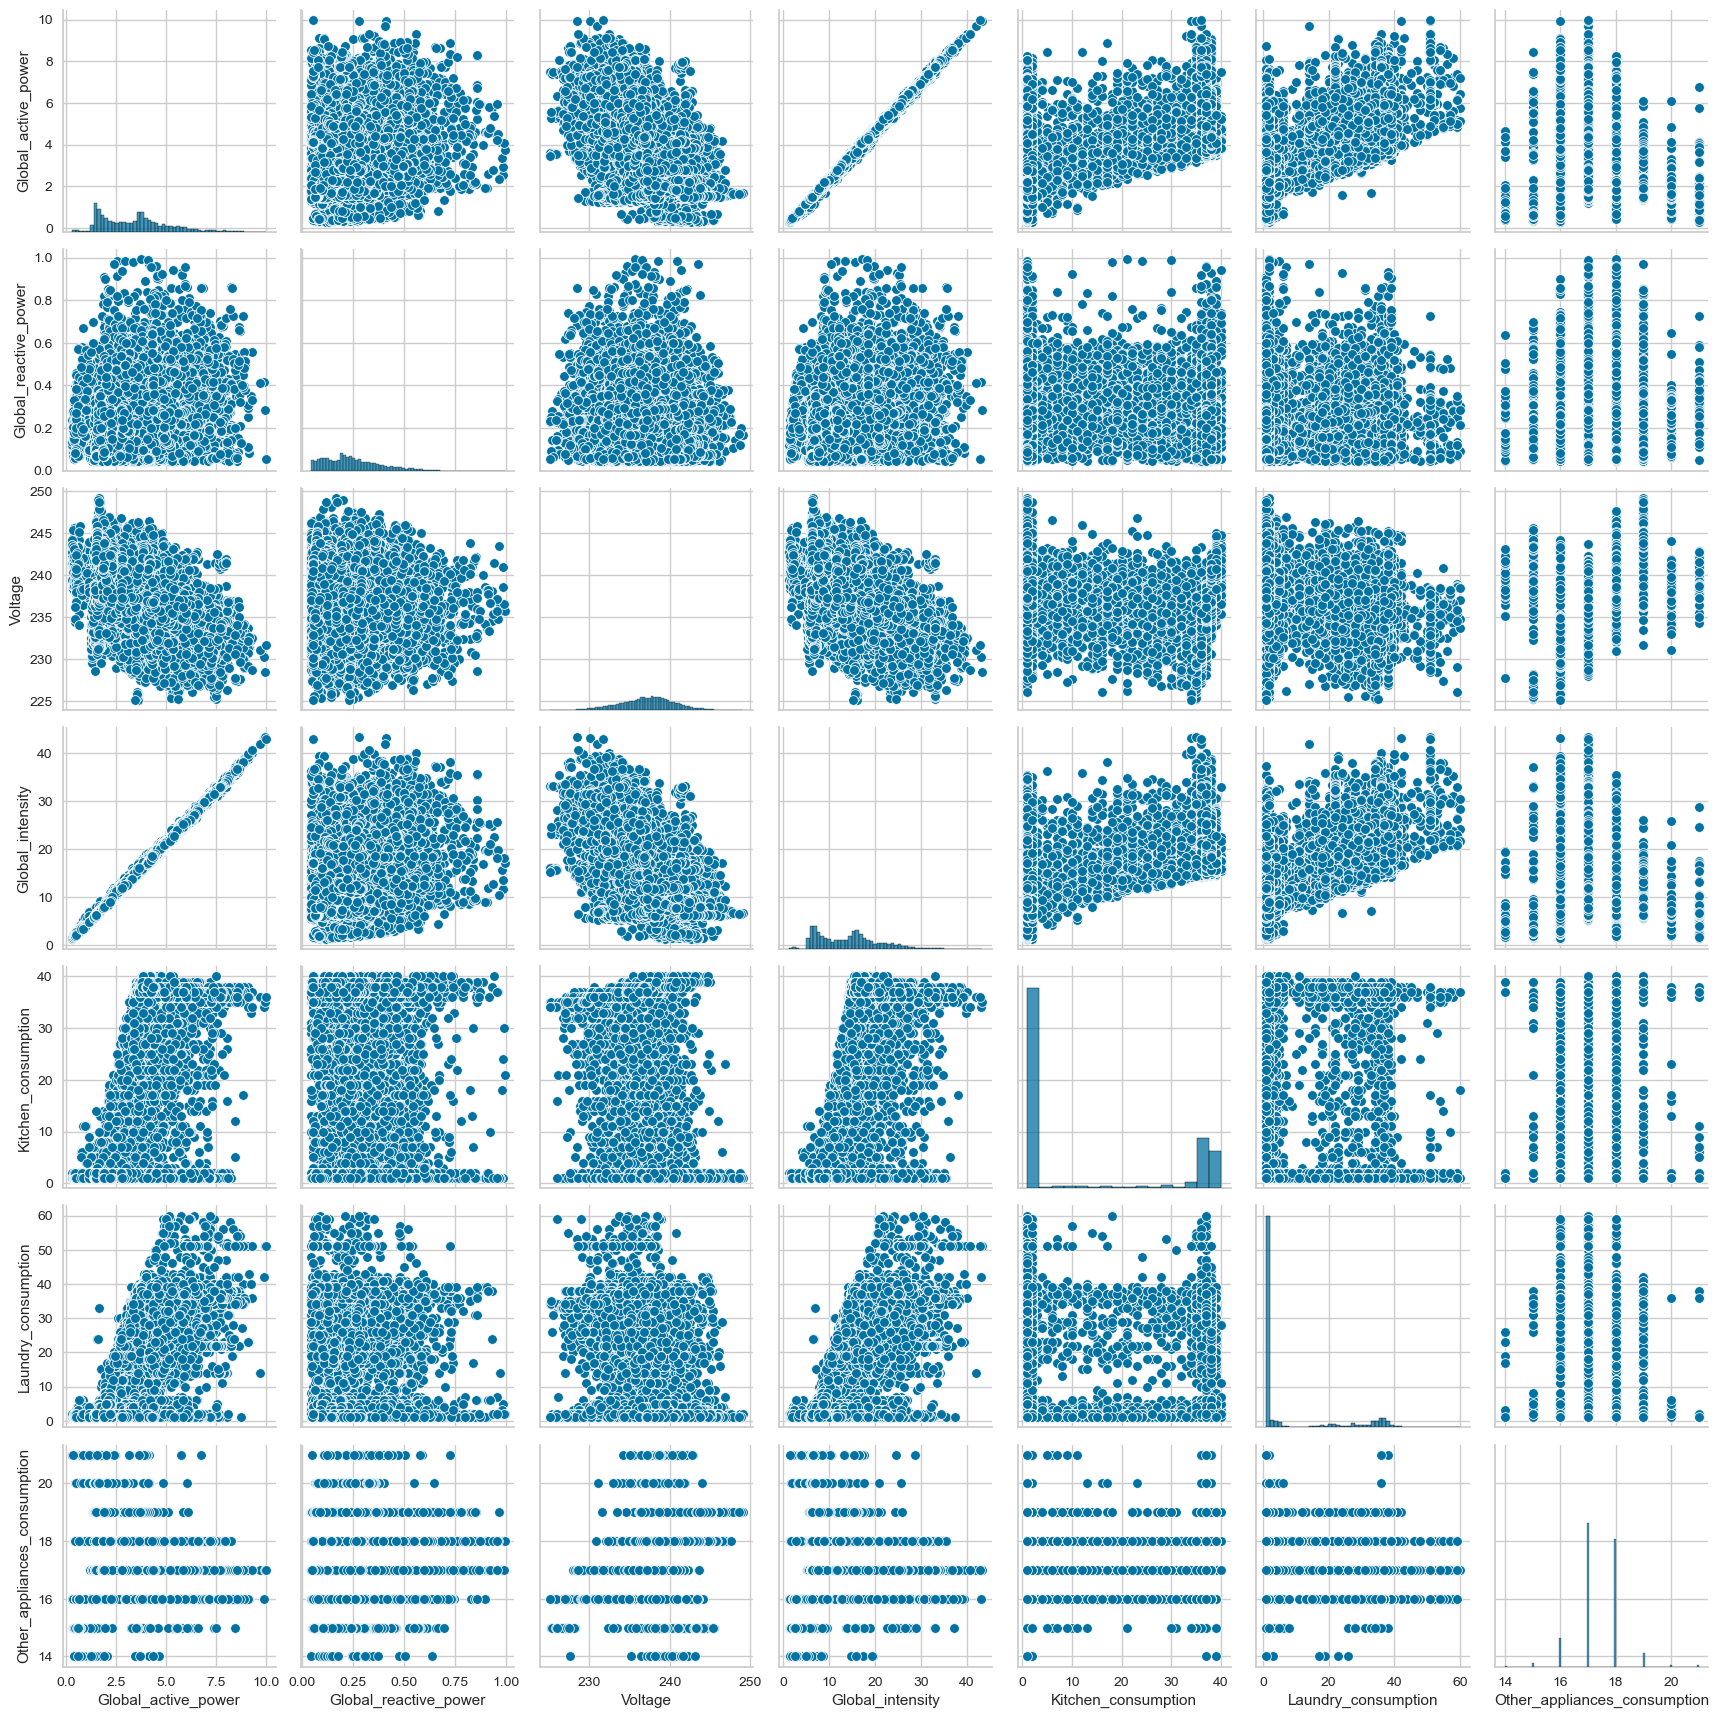

In [14]:
sns.pairplot(data)

In [15]:
# Lets scale the data

In [16]:
sc = StandardScaler()

In [17]:
data_s= data.copy()
for i in data.columns:
    data_s[i] = sc.fit_transform(pd.DataFrame(data[i]))

In [18]:
data_s

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,-0.698943,-0.647540,0.030626,-0.627039,-0.739936,-0.177339,-0.488457
1,0.206905,0.294507,-0.602426,0.203296,-0.678724,1.859146,-0.488457
2,-0.102019,0.350749,-0.358498,-0.025762,-0.739936,1.204561,-0.488457
3,0.194597,0.182024,-0.599522,0.174663,-0.739936,1.859146,-0.488457
4,-0.106942,0.266386,-0.332363,-0.054394,-0.739936,1.277293,-0.488457
...,...,...,...,...,...,...,...
21235,-0.348173,0.252326,0.530099,-0.369349,-0.678724,-0.540997,-0.488457
21236,-0.381404,0.252326,0.402327,-0.397981,-0.739936,-0.613729,0.736861
21237,-0.386327,0.224205,0.245516,-0.397981,-0.678724,-0.613729,-0.488457
21238,-0.282942,0.097661,-0.036164,-0.283452,-0.739936,-0.613729,0.736861


In [19]:
# Lets apply PCA on the dataset

In [20]:
pca = PCA(n_components=7)

In [21]:
pca.fit(data_s)

PCA(n_components=7)

In [22]:
pca.explained_variance_

array([3.36179439, 1.10833967, 1.07530084, 0.91400655, 0.36966714,
       0.17067116, 0.00058725])

In [23]:
pca.explained_variance_ratio_.cumsum()

array([0.48023116, 0.6385571 , 0.79216345, 0.92272897, 0.9755358 ,
       0.99991611, 1.        ])

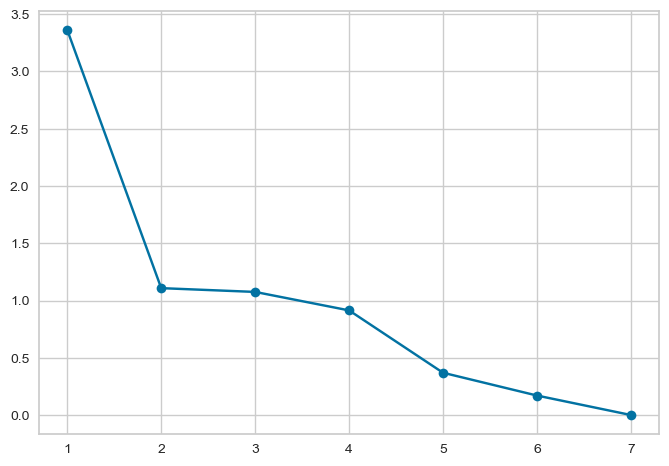

In [24]:
plt.plot(range(1,8),pca.explained_variance_,marker='o')

In [25]:
pca = PCA(n_components=2)

In [26]:
data_pca = pca.fit_transform(data_s)

In [27]:
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2'])

In [28]:
data_pca

,PC1,PC2
0,-0.935413,-1.038198
1,0.971937,-0.388768
2,0.370262,-0.462506
3,0.918359,-0.448081
4,0.358869,-0.478836
...,...,...
19070,-0.832946,-0.385916
19071,-1.200943,0.390391
19072,-0.782718,-0.550625
19073,-0.933396,0.183545


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

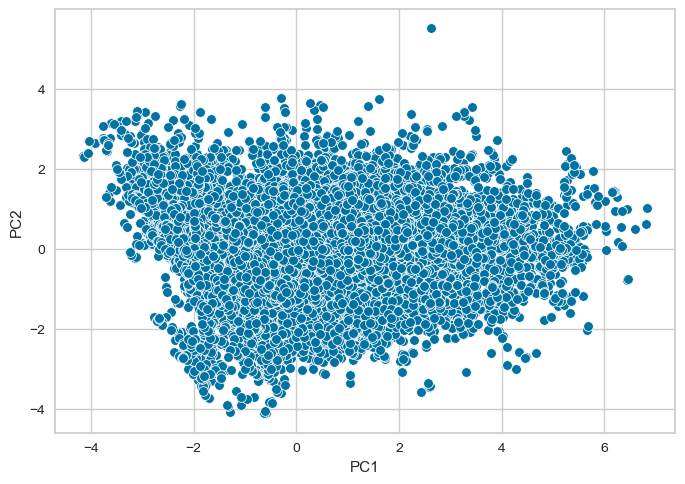

In [29]:
sns.scatterplot(data_pca['PC1'],data_pca['PC2'])

## KMeans Clustering

In [30]:
nclus= list(range(2,10))

In [31]:
wcss = []
sil = []
for i in nclus:
    model = KMeans(n_clusters=i)
    model.fit(data_pca)
    pred = model.predict(data_pca)
    wcss.append(model.inertia_)
    sil.append(silhouette_score(data_pca,pred))

In [32]:
pd.DataFrame({'WCSS':wcss,'Sil_Score':sil},index=nclus)

,WCSS,Sil_Score
2,41000.169112,0.449812
3,29993.804028,0.388205
4,21834.856273,0.396816
5,17302.834799,0.391618
6,15334.939250,0.381984
7,13474.275169,0.386719
8,11623.962079,0.368828
9,10520.916054,0.364681


In [33]:
k_elbow = KElbowVisualizer(KMeans(),k=12)

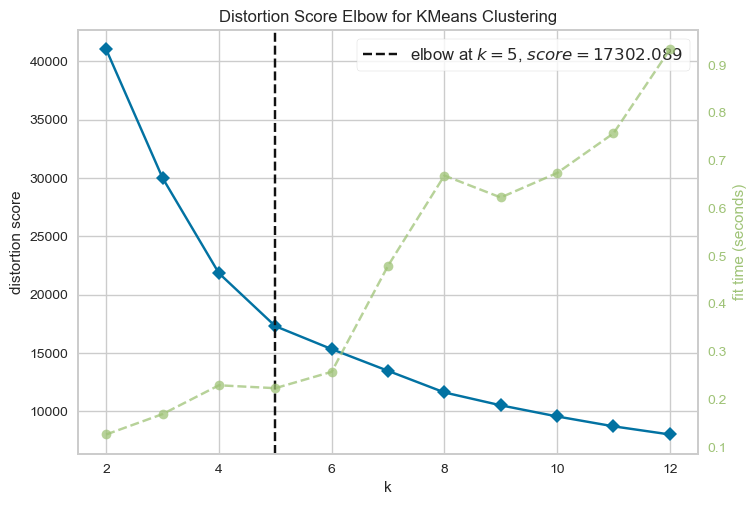

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
k_elbow.fit(data_pca)
k_elbow.show()

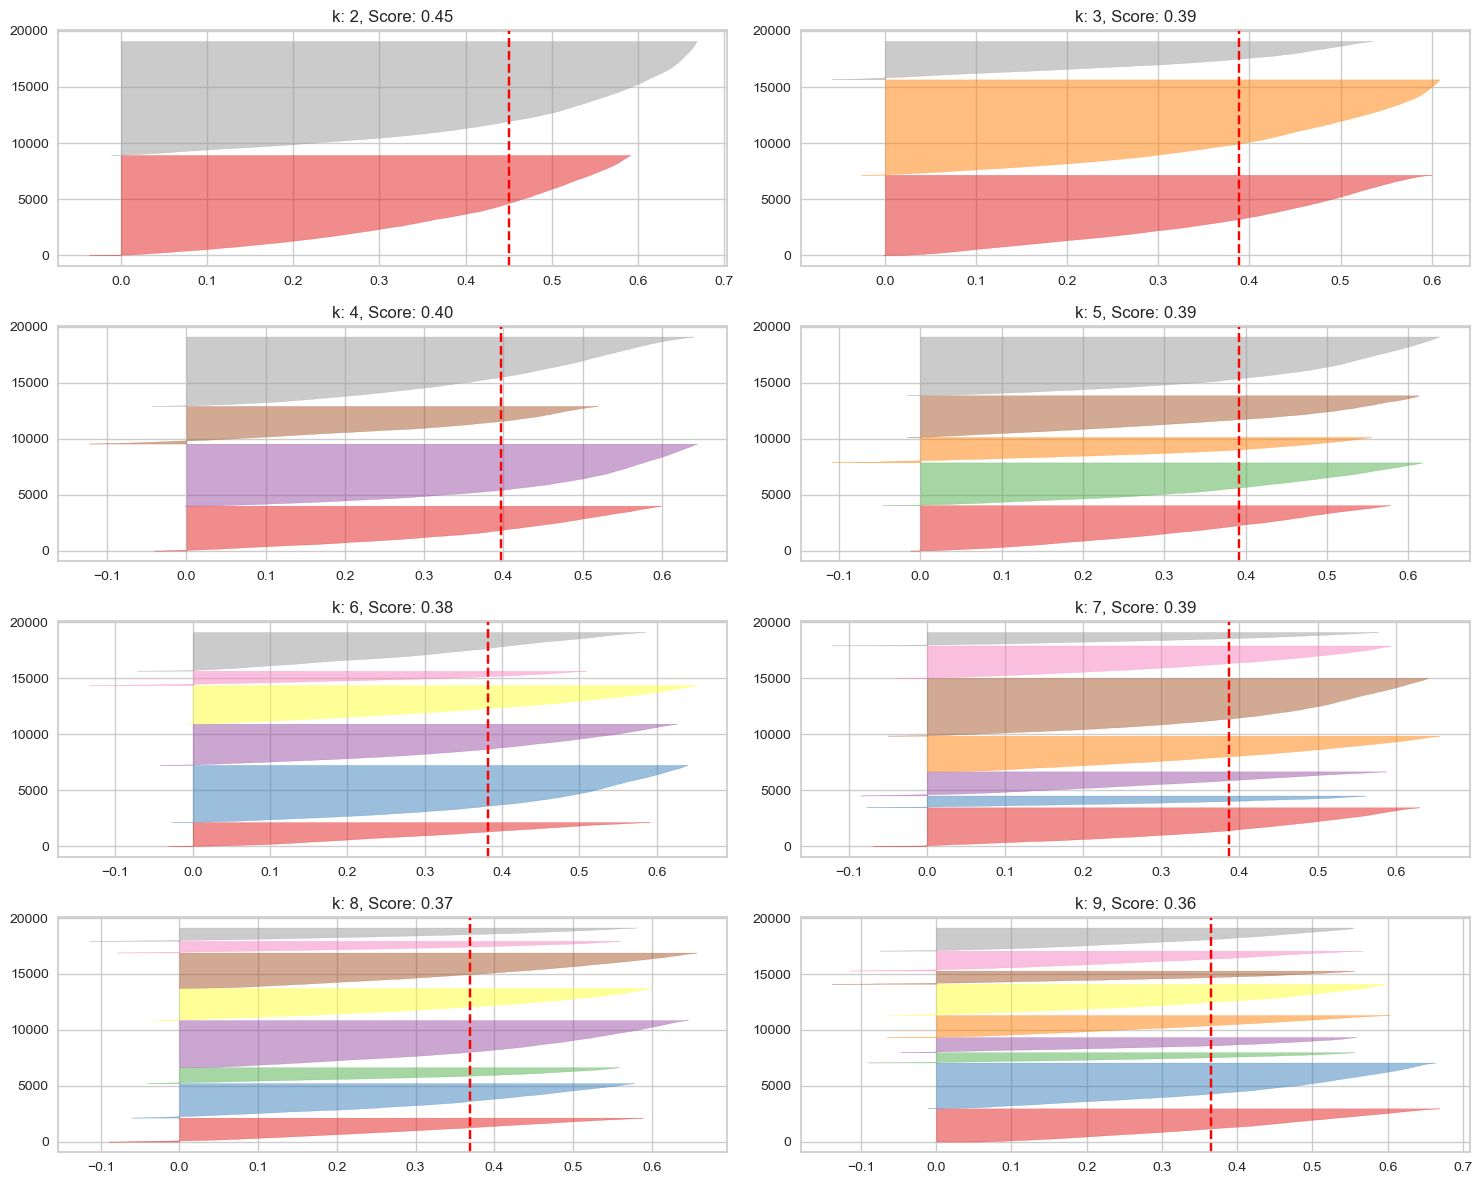

In [35]:
t=1
plt.figure(figsize=(15,12))
for i in nclus:
    plt.subplot(4,2,t)
    model = KMeans(n_clusters=i)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(data_pca)
    plt.title('k: %s, Score: %.2f'%(i,sil_viz.silhouette_score_))
    t+=1
plt.tight_layout()
plt.show()

In [36]:
# Lets go with clusters = 3

In [37]:
final_kmean = KMeans(n_clusters=3)

In [38]:
final_kmean.fit(data_pca)

KMeans(n_clusters=3)

In [39]:
y_pred_kmeans = final_kmean.predict(data_pca)

In [40]:
centroids = final_kmean.cluster_centers_

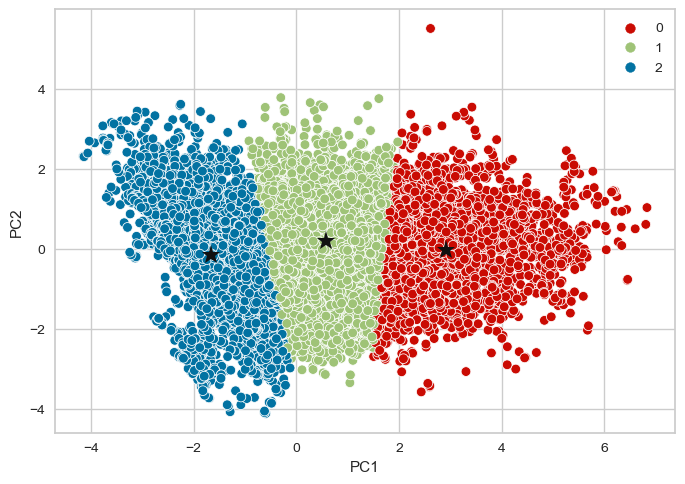

In [41]:
sns.scatterplot(data_pca['PC1'],data_pca['PC2'],hue=y_pred_kmeans,
               palette=['r','g','b'])
for i in range(3):    
    plt.plot(centroids[i][0],centroids[i][1],marker='*',ms=14,color='k')
plt.show()

In [42]:
data['Label_Kmean'] = y_pred_kmeans

In [43]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Label_Kmean
0,2.242,0.162,237.33,10.0,1,7,17,2
1,3.714,0.296,235.15,15.8,2,35,17,1
2,3.212,0.304,235.99,14.2,1,26,17,1
3,3.694,0.280,235.16,15.6,1,35,17,1
4,3.204,0.292,236.08,14.0,1,27,17,1
...,...,...,...,...,...,...,...,...
21235,2.812,0.290,239.05,11.8,2,2,17,2
21236,2.758,0.290,238.61,11.6,1,1,18,2
21237,2.750,0.286,238.07,11.6,2,1,17,2
21238,2.918,0.268,237.10,12.4,1,1,18,2


In [44]:
data.groupby(by='Label_Kmean').mean()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
Label_Kmean,,,,,,,
0,5.840198,0.284029,233.242494,25.092824,26.865519,24.067095,16.743874
1,3.905434,0.261707,236.836673,16.591571,20.103052,11.002240,17.366564
2,1.942192,0.235668,239.155226,8.204868,1.643974,2.228689,17.689477


In [45]:
data['Power_Consumption'] = data['Label_Kmean'].map({0:'Avg',2:'Low',1:'High'})

In [46]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Label_Kmean,Power_Consumption
0,2.242,0.162,237.33,10.0,1,7,17,2,Low
1,3.714,0.296,235.15,15.8,2,35,17,1,High
2,3.212,0.304,235.99,14.2,1,26,17,1,High
3,3.694,0.280,235.16,15.6,1,35,17,1,High
4,3.204,0.292,236.08,14.0,1,27,17,1,High
...,...,...,...,...,...,...,...,...,...
21235,2.812,0.290,239.05,11.8,2,2,17,2,Low
21236,2.758,0.290,238.61,11.6,1,1,18,2,Low
21237,2.750,0.286,238.07,11.6,2,1,17,2,Low
21238,2.918,0.268,237.10,12.4,1,1,18,2,Low


In [47]:
del data['Label_Kmean']

In [48]:
data['Total_Consumption'] = data.iloc[:,[4,5,6]].sum(axis=1)

In [49]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Power_Consumption,Total_Consumption
0,2.242,0.162,237.33,10.0,1,7,17,Low,25
1,3.714,0.296,235.15,15.8,2,35,17,High,54
2,3.212,0.304,235.99,14.2,1,26,17,High,44
3,3.694,0.280,235.16,15.6,1,35,17,High,53
4,3.204,0.292,236.08,14.0,1,27,17,High,45
...,...,...,...,...,...,...,...,...,...
21235,2.812,0.290,239.05,11.8,2,2,17,Low,21
21236,2.758,0.290,238.61,11.6,1,1,18,Low,20
21237,2.750,0.286,238.07,11.6,2,1,17,Low,20
21238,2.918,0.268,237.10,12.4,1,1,18,Low,20


<AxesSubplot:xlabel='Global_active_power', ylabel='Total_Consumption'>

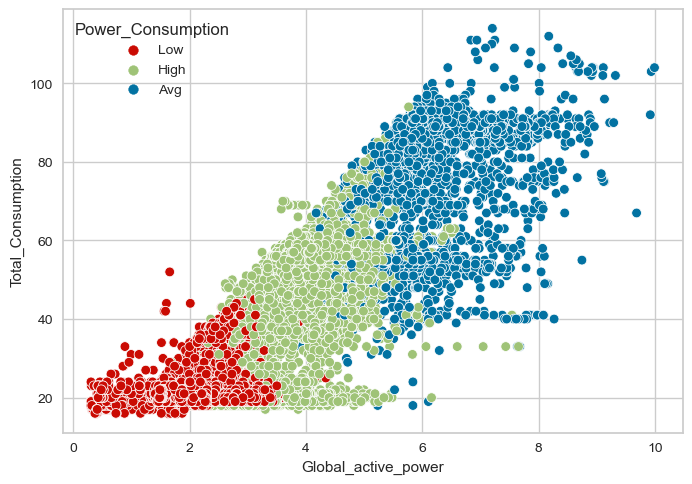

In [50]:
sns.scatterplot(data['Global_active_power'],data['Total_Consumption'],
               hue=data['Power_Consumption'],palette=['r','g','b'])